# Image Classification using Pretrained Models
In this section, we will try to classify sceneries from intel's dataset into 6 classes:
- Buildings
- Forest
- Glacier
- Mountain
- Sea
- Street

Where we will utilize different pretrained models and architectures in order to compare their performances.

In [0]:
# Importing our libraries

import time
from timeit import default_timer as timer
import torch
import torchvision
import os
from torch import nn, optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data.sampler import SubsetRandomSampler
from collections import OrderedDict
from torchsummary import summary
import torch.nn.functional as F

# Loading bar feature
from tqdm.auto import trange, tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# For reproduceability
seed = 42
torch.manual_seed(seed)
batch_size=128

device = torch.device("cuda:0")
# device = torch.device("cpu")

In [4]:
# Mount google.colab into our drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Preprocessing

We will load the data and normalize it to be similar to ImageNet's mean and standard deviation.

 We will then visualize some images and data.
 


In [5]:
# Unzipping the dataset into colab's storage.
!unzip "/content/gdrive/My Drive/EE499/Project/Dataset.zip" -d "/Data"

Streaming output truncated to the last 5000 lines.
  inflating: /Data/499 Project/sea/15615.jpg  
  inflating: /Data/499 Project/sea/15617.jpg  
  inflating: /Data/499 Project/sea/15618.jpg  
  inflating: /Data/499 Project/sea/15622.jpg  
  inflating: /Data/499 Project/sea/15635.jpg  
  inflating: /Data/499 Project/sea/15637.jpg  
  inflating: /Data/499 Project/sea/15651.jpg  
  inflating: /Data/499 Project/sea/15656.jpg  
  inflating: /Data/499 Project/sea/15659.jpg  
  inflating: /Data/499 Project/sea/15661.jpg  
  inflating: /Data/499 Project/sea/15666.jpg  
  inflating: /Data/499 Project/sea/15671.jpg  
  inflating: /Data/499 Project/sea/15691.jpg  
  inflating: /Data/499 Project/sea/1570.jpg  
  inflating: /Data/499 Project/sea/15703.jpg  
  inflating: /Data/499 Project/sea/15711.jpg  
  inflating: /Data/499 Project/sea/15715.jpg  
  inflating: /Data/499 Project/sea/15736.jpg  
  inflating: /Data/499 Project/sea/15753.jpg  
  inflating: /Data/499 Project/sea/15769.jpg  
  inflatin

In [0]:
# Dataset Directory
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
data_dir = "/Data/499 Project"

In [0]:
# display the image and undo the processing.
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    image = np.transpose(image, (1, 2, 0))  
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * np.array(image) + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    plt.title(title)
    return None

In [0]:
# Splits the dataset into training, validation, and testing loaders
def get_train_valid_test_loader(data_dir,batch_size,
                           augment,
                           random_seed,
                           valid_size=0.15,
                           test_size = 0.20,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=True):
  # Defining Transforms
  if augment:
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                        transforms.RandomResizedCrop(224),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])
    valid_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

    test_transforms = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
  # Loading datasets
  train_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
  valid_dataset = datasets.ImageFolder(data_dir, transform=valid_transforms)
  test_dataset = datasets.ImageFolder(data_dir, transform=test_transforms)
  train_nonaug = datasets.ImageFolder(data_dir, transform=valid_transforms)
  
  # Setting the indices
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split_valid = int(np.floor(valid_size * num_train))
  split_test = split_valid + int(np.floor(test_size * num_train))

  # Randomly shuffling the indices
  if shuffle:
      np.random.seed(random_seed)
      np.random.shuffle(indices)
  # Sampling the elements randomly from the indices 
  valid_idx, test_idx, train_idx = indices[:split_valid], indices[split_valid:split_test], indices[split_test:]
  train_sampler = SubsetRandomSampler(train_idx)
  # valid_sampler = SubsetRandomSampler(valid_idx)
  # test_sampler = SubsetRandomSampler(test_idx)
  
  # Using a subset instead of a sampler, for stability during iterations
  valid_dataset = torch.utils.data.Subset(valid_dataset,valid_idx)
  test_dataset = torch.utils.data.Subset(test_dataset,test_idx)

  # Iterate over the dataset by batches
  train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size,# sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size,# sampler=test_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  train_nonaug_loader = torch.utils.data.DataLoader(
        train_nonaug, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory)
  
  # How many samples are in each split
  print("Number of training samples: {:d}\nNumber of validation samples: {:d}\nNumber of test samples: {:d}".format(len(train_idx),len(valid_idx),len(test_idx)))
  return train_loader, valid_loader, test_loader, train_nonaug_loader
  


In [9]:
# Loading the data
train_loader, valid_loader, test_loader, train_nonaug_loader = get_train_valid_test_loader(data_dir,batch_size,True,seed)

Number of training samples: 11073
Number of validation samples: 2555
Number of test samples: 3406


In [0]:
# Check the images from the loaders
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
dataiter_valid = iter(valid_loader)
dataiter_train = iter(train_loader)

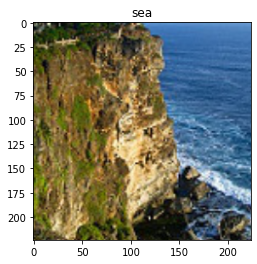

In [0]:
# Iterate through the test loader
images, labels = dataiter_valid.next()
imshow(torchvision.utils.make_grid(images[0]),title=classes[labels[0]])

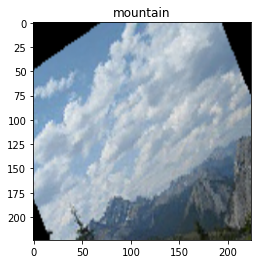

In [0]:
# Check the images from the augmented training loader
images, labels = dataiter_train.next()
imshow(torchvision.utils.make_grid(images[0]),title=classes[labels[0]])

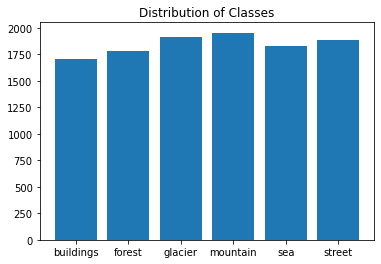

The mean of the distribution is: 1845.50
The standard deviation of the distribution is: 83.09


In [0]:
# Show distribution of classes of the training set (can be changed to valid or test)
def get_class_distribution(loader):
  count = {
        "buildings": 0,
        "forest": 0,
        "glacier": 0,
        "mountain": 0,
        "sea": 0,
        "street": 0,
    }
  for data in loader:
    images, labels = data
    count["buildings"] += (0 == labels).sum().item()
    count["forest"] += (1 == labels).sum().item()
    count["glacier"] += (2 == labels).sum().item()
    count["mountain"] += (3 == labels).sum().item()
    count["sea"] += (4 == labels).sum().item()
    count["street"] += (5 == labels).sum().item()
  return count

count = get_class_distribution(train_loader)
plt.bar(range(len(count)), list(count.values()), align='center')
plt.xticks(range(len(count)), list(count.keys()))
plt.title("Distribution of Classes")
plt.show()
print("The mean of the distribution is: {:.2f}\nThe standard deviation of the distribution is: {:.2f}".format(np.array(list(count.values())).mean(),np.array(list(count.values())).std()))

## Setting Up the Model
Here we will pick from the following models:


1.   vgg16
2.   vgg19
3.   resnet50
4.   squeezenet



In [0]:
def load_model(name):
  
    # Download pretrained model and freeze parameters so we don't backprop through them
    if name == 'vgg19':
      model = models.vgg19(pretrained=True)
      for param in model.parameters():
       param.requires_grad = False
      n_inputs = model.classifier[0].in_features
      model.classifier = nn.Sequential(
                   nn.Linear(n_inputs, 4096), 
                   nn.LeakyReLU(negative_slope=0.1), 
                   nn.Dropout(0.15),
                   nn.Linear(4096,1024),
                   nn.LeakyReLU(negative_slope=0.1),
                   nn.Dropout(0.15),
                   nn.Linear(1024,256),
                   nn.LeakyReLU(negative_slope=0.1),
                   nn.Dropout(0.15),
                   nn.Linear(256, 6),                   
                   nn.LogSoftmax(dim=1))
      model.name = name
    elif name == 'vgg16':
      model = models.vgg16(pretrained=True)
      model.name = name
      for param in model.parameters():
       param.requires_grad = False
      n_inputs = model.classifier[6].in_features
      model.classifier[6] = nn.Sequential( #First 5 layers are not trained
                   nn.Linear(n_inputs, 6),                   
                   nn.LogSoftmax(dim=1))
      
    elif name == 'resnet50':
      model = models.resnet50(pretrained=True)
      model.name = name
      for param in model.parameters():
       param.requires_grad = False
      n_inputs = model.fc.in_features
      model.fc = nn.Sequential(
      nn.Linear(n_inputs, 6), nn.LogSoftmax(dim=1))

    elif name == 'squeezenet':
      model = models.squeezenet1_1(pretrained=True)
      model.name = name
      for param in model.parameters():
       param.requires_grad = False
      model.classifier[1] = nn.Conv2d(512, 6, kernel_size=(1,1), stride=(1,1))
      model.classifier = nn.Sequential(model.classifier,nn.LogSoftmax(dim=1))
    else:
      print("The model picked is not from our selection.")
      return None
    
    return model

In [11]:
# Setting up our pretrained model
name = 'vgg16'
model = load_model(name)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [12]:
# Load the model into CUDA (GPU)
model.to(device)
# Get a summary of the model and the number of trainable parameters

summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')
print('GPU:', torch.cuda.get_device_name(0))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 112, 112]           9,408
       BatchNorm2d-2        [128, 64, 112, 112]             128
              ReLU-3        [128, 64, 112, 112]               0
         MaxPool2d-4          [128, 64, 56, 56]               0
            Conv2d-5          [128, 64, 56, 56]           4,096
       BatchNorm2d-6          [128, 64, 56, 56]             128
              ReLU-7          [128, 64, 56, 56]               0
            Conv2d-8          [128, 64, 56, 56]          36,864
       BatchNorm2d-9          [128, 64, 56, 56]             128
             ReLU-10          [128, 64, 56, 56]               0
           Conv2d-11         [128, 256, 56, 56]          16,384
      BatchNorm2d-12         [128, 256, 56, 56]             512
           Conv2d-13         [128, 256, 56, 56]          16,384
      BatchNorm2d-14         [128, 256,

In [0]:
# Set the criterion as Negative Log Likelihood
criterion = nn.NLLLoss()
if model.name == 'resnet50':
  # Use this for resnet
  model.optimizer = optim.Adam(model.fc.parameters(),lr=3e-4)
else:
  # Use this otherwise
  model.optimizer = optim.Adam(model.classifier.parameters(), lr=3e-4)


In [0]:
# Function to get the loss and accuracy 
def validation(model, testloader, criterion):
  # Initializing
  test_loss = 0
  accuracy = 0
  for ii, (inputs, labels) in enumerate(testloader):
    
    # Load the data into CUDA
    inputs, labels = inputs.to(device), labels.to(device)

    # Get the logarithmic probability of each class
    output = model.forward(inputs)
    # Keep summing the loss
    test_loss += criterion(output, labels).item()
    
    # Get the probablity of each class
    ps = torch.exp(output)

    # Aquire the accuracy by comparing the predictions
    equality = (labels.data == ps.max(dim=1)[1])
    accuracy += equality.type(torch.FloatTensor).mean()
  return test_loss, accuracy

In [0]:
# Training with early stopping (Main)
save = '/Data/model.pt'
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file,
          early_stop_epochs=7,
          epochs = 30):
  # Training Initilizing
  start_training_time = time.time()
  start = time.time()
  history = []
  epochs_no_improve = 0
  valid_loss_min = np.Inf
  valid_max_acc = 0

  print("The training process has started. \n")
  for e in range(epochs):
    # Initilizing for each epoch
      running_loss = 0
      model.train() 
      total_train = 0
      correct_train = 0
      
      # Using tqdm's loading bar when iterating through the data
      for ii, (inputs, labels) in tqdm(enumerate(train_loader),total=len(train_loader),desc='Epoch progress'):
          
          # Load the the data into CUDA
          inputs, labels = inputs.to(device), labels.to(device)

          # Setting the gradients to zero
          optimizer.zero_grad()
          
          # Forward and backward passes
          outputs = model.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          running_loss += loss.item()
          
          # Obtain the training loss and accuracy of the model
          _, predicted = torch.max(outputs,1)
          total_train += labels.nelement()
          correct_train += predicted.eq(labels).sum().item()
          train_acc = correct_train/total_train

      # Get the validation loss and accuracy
      model.eval()
      with torch.no_grad():
          valid_loss, valid_acc = validation(model, valid_loader, criterion)
      # Print the losses and accuracies
      print("Epoch: {}/{} | ".format(e+1, epochs),
            "Training Loss: {:.4f} | ".format(running_loss/len(train_loader)),
            "Training Accuracy: {:.2f}% |".format(100*train_acc),
            "Validation Loss: {:.4f} | ".format(valid_loss/len(valid_loader)),
            "Validation Accuracy: {:.2f}% |".format(100*valid_acc/len(valid_loader)),
            "Time elapsed: {:.2f} seconds".format((time.time()-start)))
      # Obtain current time in seconds.
      start = time.time()
      # Append the losses and accuracies to the history list
      history.append([running_loss/len(train_loader),100*train_acc,valid_loss/len(valid_loader),100*valid_acc/len(valid_loader)])

      # Check if the validaton loss is lower than the minmum recorded loss
      if valid_loss/len(valid_loader) < valid_loss_min:
        # Save the model weights and parameters
        torch.save(model.state_dict(), save_file)
        # Reinitialize counter
        epochs_no_improve = 0
        # Record minimum loss and best accuracy
        valid_loss_min = valid_loss/len(valid_loader)
        valid_best_acc = 100*valid_acc/len(valid_loader)
        best_epoch = e+1
      else:
        # Count up
        epochs_no_improve += 1

        # Early stop the training if number of epochs exceeded the chosen number
        if epochs_no_improve >= early_stop_epochs:
          print("Early Stopping...Total epochs: {}. Best epoch: {} with loss: {:4f} and accuracy: {:.2f}".format(e+1,best_epoch,valid_loss_min,valid_best_acc))
          # Load best model
          model.load_state_dict(torch.load(save_file))
          # Attach optimizer to the model
          model.optimizer = optimizer
          # Convert history to DataFrame
          history = pd.DataFrame(
                    history,
                    columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
          return model, history


      model.train()
      
  end_training_time = time.time()
  # Load best model
  model.load_state_dict(torch.load(save_file))
  # Attach the optimizer to the model
  model.optimizer = optimizer
  # Convert history to DataFrame
  history = pd.DataFrame(
    history,
    columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
  print('\nTraining of the model was completed in {:.2f} minutes.'.format((end_training_time-start_training_time)/60))
  return model, history

In [16]:
# Set a temporary save directory for the model during training
save = '/Data/model.pt'
# Train the model and obtain the history
model, history = train(model,criterion,model.optimizer,train_nonaug_loader,valid_loader,save,early_stop_epochs=10,epochs=50)

The training process has started. 




Epoch: 1/50 |  Training Loss: 0.8904 |  Training Accuracy: 77.86% | Validation Loss: 0.5071 |  Validation Accuracy: 87.70% | Time elapsed: 59.08 seconds



Epoch: 2/50 |  Training Loss: 0.4334 |  Training Accuracy: 88.80% | Validation Loss: 0.3721 |  Validation Accuracy: 88.92% | Time elapsed: 58.76 seconds



Epoch: 3/50 |  Training Loss: 0.3506 |  Training Accuracy: 89.45% | Validation Loss: 0.3235 |  Validation Accuracy: 89.70% | Time elapsed: 59.42 seconds



Epoch: 4/50 |  Training Loss: 0.3137 |  Training Accuracy: 90.01% | Validation Loss: 0.3052 |  Validation Accuracy: 89.30% | Time elapsed: 59.49 seconds



Epoch: 5/50 |  Training Loss: 0.2899 |  Training Accuracy: 90.68% | Validation Loss: 0.2898 |  Validation Accuracy: 89.86% | Time elapsed: 59.63 seconds



Epoch: 6/50 |  Training Loss: 0.2787 |  Training Accuracy: 90.60% | Validation Loss: 0.2800 |  Validation Accuracy: 90.13% | Time elapsed: 59.79 seconds



Epoch: 7/50 |  Training Loss: 0.2653 |  Training Accuracy: 91.22% | Validation Loss: 0.2694 |  Validation Accuracy: 90.37% | Time elapsed: 59.81 seconds



Epoch: 8/50 |  Training Loss: 0.2583 |  Training Accuracy: 91.29% | Validation Loss: 0.2626 |  Validation Accuracy: 90.64% | Time elapsed: 59.85 seconds



Epoch: 9/50 |  Training Loss: 0.2514 |  Training Accuracy: 91.28% | Validation Loss: 0.2584 |  Validation Accuracy: 90.60% | Time elapsed: 59.60 seconds



Epoch: 10/50 |  Training Loss: 0.2452 |  Training Accuracy: 91.50% | Validation Loss: 0.2553 |  Validation Accuracy: 90.64% | Time elapsed: 59.70 seconds



Epoch: 11/50 |  Training Loss: 0.2408 |  Training Accuracy: 91.54% | Validation Loss: 0.2574 |  Validation Accuracy: 90.05% | Time elapsed: 59.54 seconds



Epoch: 12/50 |  Training Loss: 0.2357 |  Training Accuracy: 91.70% | Validation Loss: 0.2519 |  Validation Accuracy: 90.72% | Time elapsed: 59.63 seconds



Epoch: 13/50 |  Training Loss: 0.2328 |  Training Accuracy: 91.58% | Validation Loss: 0.2544 |  Validation Accuracy: 90.48% | Time elapsed: 59.78 seconds



Epoch: 14/50 |  Training Loss: 0.2290 |  Training Accuracy: 91.96% | Validation Loss: 0.2490 |  Validation Accuracy: 90.25% | Time elapsed: 59.58 seconds



Epoch: 15/50 |  Training Loss: 0.2256 |  Training Accuracy: 91.93% | Validation Loss: 0.2441 |  Validation Accuracy: 90.84% | Time elapsed: 60.08 seconds



Epoch: 16/50 |  Training Loss: 0.2221 |  Training Accuracy: 92.03% | Validation Loss: 0.2425 |  Validation Accuracy: 91.03% | Time elapsed: 59.80 seconds



Epoch: 17/50 |  Training Loss: 0.2193 |  Training Accuracy: 92.11% | Validation Loss: 0.2504 |  Validation Accuracy: 89.89% | Time elapsed: 59.80 seconds



Epoch: 18/50 |  Training Loss: 0.2224 |  Training Accuracy: 91.78% | Validation Loss: 0.2411 |  Validation Accuracy: 91.11% | Time elapsed: 59.80 seconds



Epoch: 19/50 |  Training Loss: 0.2148 |  Training Accuracy: 92.46% | Validation Loss: 0.2457 |  Validation Accuracy: 90.60% | Time elapsed: 59.78 seconds



Epoch: 20/50 |  Training Loss: 0.2152 |  Training Accuracy: 92.22% | Validation Loss: 0.2381 |  Validation Accuracy: 90.72% | Time elapsed: 59.57 seconds



Epoch: 21/50 |  Training Loss: 0.2113 |  Training Accuracy: 92.40% | Validation Loss: 0.2395 |  Validation Accuracy: 91.15% | Time elapsed: 59.92 seconds



Epoch: 22/50 |  Training Loss: 0.2065 |  Training Accuracy: 92.64% | Validation Loss: 0.2478 |  Validation Accuracy: 90.41% | Time elapsed: 59.54 seconds



Epoch: 23/50 |  Training Loss: 0.2096 |  Training Accuracy: 92.31% | Validation Loss: 0.2390 |  Validation Accuracy: 90.83% | Time elapsed: 59.73 seconds



Epoch: 24/50 |  Training Loss: 0.2070 |  Training Accuracy: 92.46% | Validation Loss: 0.2420 |  Validation Accuracy: 90.29% | Time elapsed: 59.68 seconds



Epoch: 25/50 |  Training Loss: 0.2037 |  Training Accuracy: 92.72% | Validation Loss: 0.2417 |  Validation Accuracy: 90.91% | Time elapsed: 59.76 seconds



Epoch: 26/50 |  Training Loss: 0.2016 |  Training Accuracy: 92.84% | Validation Loss: 0.2341 |  Validation Accuracy: 90.99% | Time elapsed: 59.94 seconds



Epoch: 27/50 |  Training Loss: 0.2012 |  Training Accuracy: 92.69% | Validation Loss: 0.2352 |  Validation Accuracy: 91.19% | Time elapsed: 59.60 seconds



Epoch: 28/50 |  Training Loss: 0.1994 |  Training Accuracy: 92.65% | Validation Loss: 0.2355 |  Validation Accuracy: 90.91% | Time elapsed: 59.89 seconds



Epoch: 29/50 |  Training Loss: 0.1968 |  Training Accuracy: 92.87% | Validation Loss: 0.2358 |  Validation Accuracy: 91.50% | Time elapsed: 59.88 seconds



Epoch: 30/50 |  Training Loss: 0.1975 |  Training Accuracy: 92.77% | Validation Loss: 0.2413 |  Validation Accuracy: 90.68% | Time elapsed: 59.65 seconds



Epoch: 31/50 |  Training Loss: 0.1923 |  Training Accuracy: 92.95% | Validation Loss: 0.2323 |  Validation Accuracy: 91.19% | Time elapsed: 59.49 seconds



Epoch: 32/50 |  Training Loss: 0.1959 |  Training Accuracy: 93.04% | Validation Loss: 0.2325 |  Validation Accuracy: 91.23% | Time elapsed: 60.08 seconds



Epoch: 33/50 |  Training Loss: 0.1914 |  Training Accuracy: 92.88% | Validation Loss: 0.2406 |  Validation Accuracy: 90.80% | Time elapsed: 59.86 seconds



Epoch: 34/50 |  Training Loss: 0.1891 |  Training Accuracy: 93.25% | Validation Loss: 0.2362 |  Validation Accuracy: 90.84% | Time elapsed: 59.76 seconds



Epoch: 35/50 |  Training Loss: 0.1892 |  Training Accuracy: 93.14% | Validation Loss: 0.2338 |  Validation Accuracy: 90.95% | Time elapsed: 59.70 seconds



Epoch: 36/50 |  Training Loss: 0.1880 |  Training Accuracy: 92.87% | Validation Loss: 0.2309 |  Validation Accuracy: 91.34% | Time elapsed: 59.64 seconds



Epoch: 37/50 |  Training Loss: 0.1876 |  Training Accuracy: 93.01% | Validation Loss: 0.2311 |  Validation Accuracy: 91.30% | Time elapsed: 59.95 seconds



Epoch: 38/50 |  Training Loss: 0.1873 |  Training Accuracy: 93.09% | Validation Loss: 0.2295 |  Validation Accuracy: 91.50% | Time elapsed: 59.85 seconds



Epoch: 39/50 |  Training Loss: 0.1858 |  Training Accuracy: 93.18% | Validation Loss: 0.2341 |  Validation Accuracy: 91.19% | Time elapsed: 59.78 seconds



Epoch: 40/50 |  Training Loss: 0.1853 |  Training Accuracy: 93.28% | Validation Loss: 0.2308 |  Validation Accuracy: 91.11% | Time elapsed: 59.66 seconds



Epoch: 41/50 |  Training Loss: 0.1844 |  Training Accuracy: 93.25% | Validation Loss: 0.2357 |  Validation Accuracy: 90.88% | Time elapsed: 59.58 seconds



Epoch: 42/50 |  Training Loss: 0.1820 |  Training Accuracy: 93.29% | Validation Loss: 0.2367 |  Validation Accuracy: 90.56% | Time elapsed: 59.81 seconds



Epoch: 43/50 |  Training Loss: 0.1784 |  Training Accuracy: 93.40% | Validation Loss: 0.2289 |  Validation Accuracy: 91.38% | Time elapsed: 59.80 seconds



Epoch: 44/50 |  Training Loss: 0.1805 |  Training Accuracy: 93.44% | Validation Loss: 0.2363 |  Validation Accuracy: 91.07% | Time elapsed: 59.97 seconds



Epoch: 45/50 |  Training Loss: 0.1800 |  Training Accuracy: 93.51% | Validation Loss: 0.2320 |  Validation Accuracy: 91.15% | Time elapsed: 59.85 seconds



Epoch: 46/50 |  Training Loss: 0.1809 |  Training Accuracy: 93.44% | Validation Loss: 0.2321 |  Validation Accuracy: 91.27% | Time elapsed: 59.34 seconds



Epoch: 47/50 |  Training Loss: 0.1786 |  Training Accuracy: 93.73% | Validation Loss: 0.2328 |  Validation Accuracy: 91.11% | Time elapsed: 59.68 seconds



Epoch: 48/50 |  Training Loss: 0.1776 |  Training Accuracy: 93.63% | Validation Loss: 0.2334 |  Validation Accuracy: 90.76% | Time elapsed: 59.66 seconds



Epoch: 49/50 |  Training Loss: 0.1742 |  Training Accuracy: 93.71% | Validation Loss: 0.2318 |  Validation Accuracy: 91.23% | Time elapsed: 60.18 seconds



Epoch: 50/50 |  Training Loss: 0.1739 |  Training Accuracy: 93.75% | Validation Loss: 0.2346 |  Validation Accuracy: 90.80% | Time elapsed: 60.47 seconds

Training of the model was completed in 49.77 minutes.


# Visualizing the Results



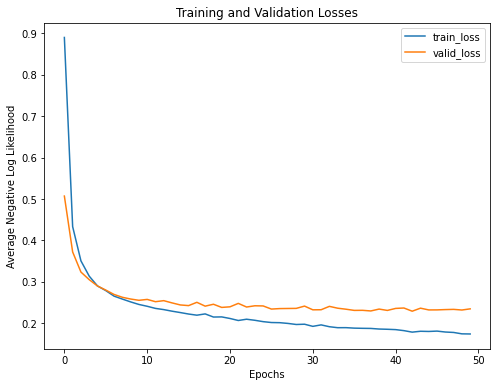

In [17]:
# Plot the training and validation loss vs epochs

fig = plt.figure(figsize=(8, 6))
for c in ['train_loss',
          'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()
fig.savefig('/content/gdrive/My Drive/EE499/Project/Figures/resnet50.png')

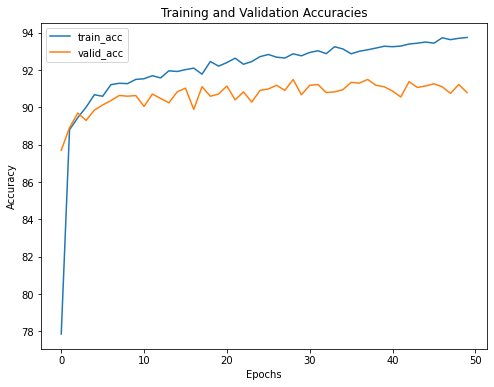

In [18]:
# Plot the training and validation accuracies vs epochs
fig = plt.figure(figsize=(8, 6))
for c in ['train_acc',
          'valid_acc']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.show()
fig.savefig('/content/gdrive/My Drive/EE499/Project/Figures/resnet50.png')

In [0]:
# Convert the history to an excel file and save it
history.to_excel('/content/gdrive/My Drive/EE499/Project/History/squeeze.xlsx')

In [38]:
# Testing the accuracy of the model
def get_predictions(model, loader):

    model.eval()
    # Initializing
    labelsl = []
    probs = []
    with torch.no_grad():

        for (images, labels) in loader:
            # Load the images to CUDA
            images = images.to(device)
            # Get the logarithmic probability
            y_prob = model(images)
            # Get the probability
            y_prob = torch.exp(y_prob)
            # Append the images, labels, and probabilites to their lists
            labelsl.append(labels.cpu())
            probs.append(y_prob.cpu())
    # Convert them to tensors   
    labels = torch.cat(labelsl, dim = 0)
    probs = torch.cat(probs, dim = 0)
    # Get the predicted
    pred_labels = torch.argmax(probs, 1)
    # Empty VRAM
    torch.cuda.empty_cache()
    return labels, probs, pred_labels
labels, probs, pred_labels = get_predictions(model,test_loader)
print('Accuracy achieved by the network on test images is: {:.2f}%'.format(100 *accuracy_score(labels,pred_labels)))

Accuracy achieved by the network on test images is: 91.31%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


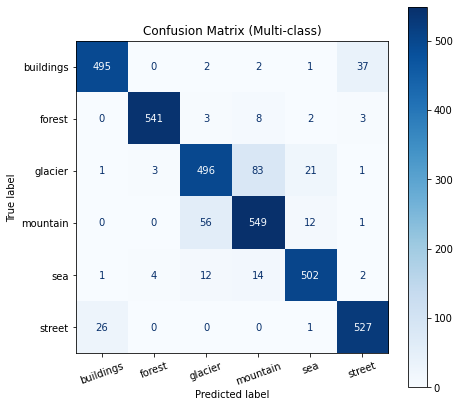

In [39]:
# Using sklearn's confusion matrix plot
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (7, 7));
    plt.title("Confusion Matrix (Multi-class)")
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.show()
plot_confusion_matrix(labels, pred_labels, classes)

In [0]:
# Setup iterator
dataiter = iter(test_loader)

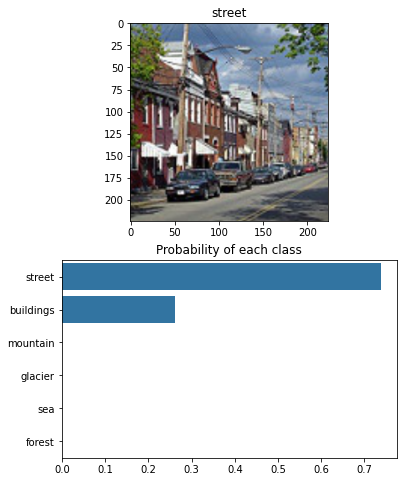

The image was classified correctly.


In [28]:
# Sanity check for the model
with torch.no_grad():
  model.eval()
  # Define the classes
  classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
  # Iterator of the loader
  images, labels = dataiter.next()
  plt.figure(figsize=(6,8))
  ax = plt.subplot(2,1,1)
  # Show the image with the label as the title
  imshow(torchvision.utils.make_grid(images[0]), ax, title=classes[labels[0]])
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  outputs = outputs.cpu()
  # Get the predictions of the first image
  output = (torch.exp(outputs[0]))
  # Obtain the top probabilities with their indices
  prob, idx = torch.topk(output,6)
  plt.subplot(2,1,2)
  # Reorder the classes list to be like the indices
  topsix= [classes[i] for i in idx]
  # Plot the probabilities
  sns.barplot(x=prob, y=topsix,color=sns.color_palette()[0])
  plt.title("Probability of each class")
  plt.show()
  # Print if the image is classified correctly or not
  if labels[0] == idx[0]:
    print("The image was classified correctly.")
  else:
    print("The image was classified incorrectly.")
  

In [0]:
# Set up iterator
dataiter = iter(test_loader)

Plotting misclassified data:


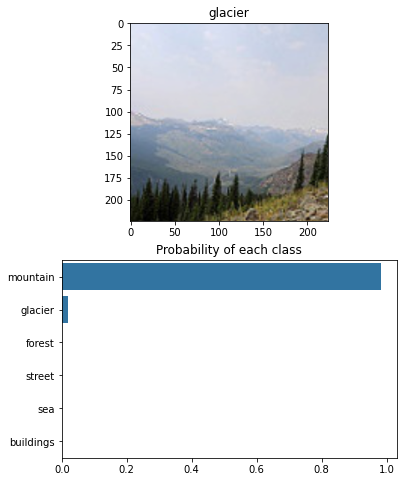

The image was classified incorrectly.


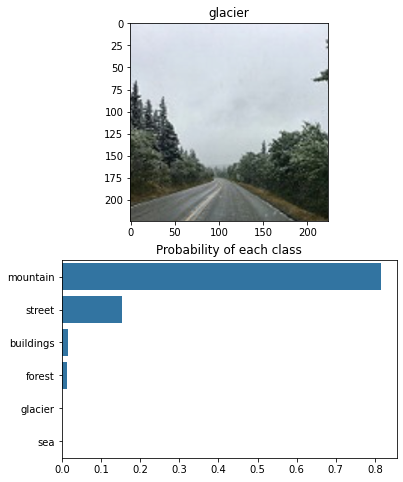

The image was classified incorrectly.


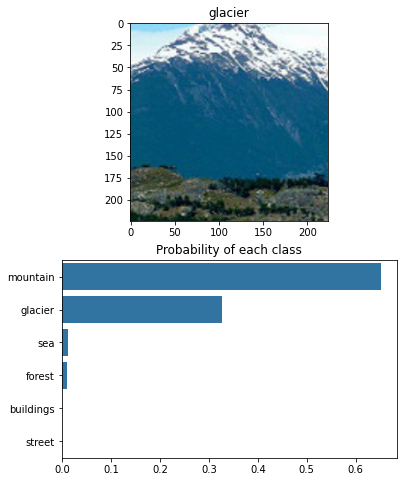

The image was classified incorrectly.


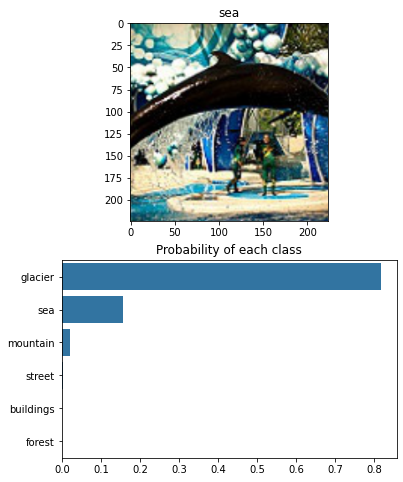

The image was classified incorrectly.


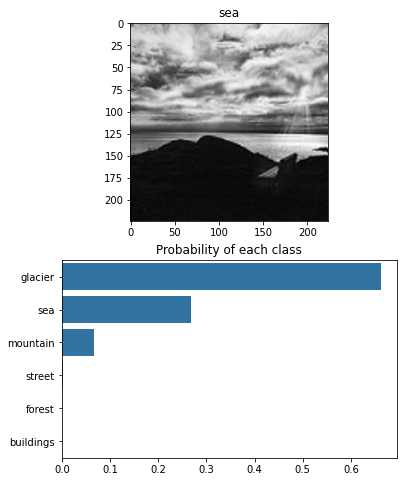

The image was classified incorrectly.


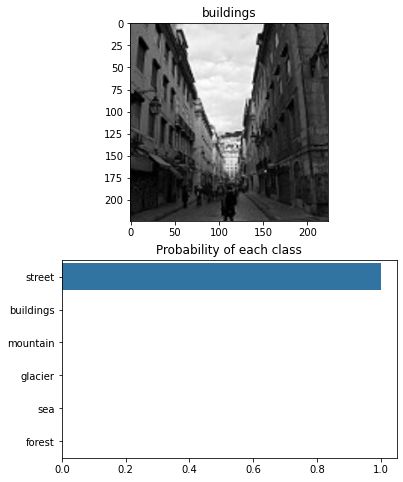

The image was classified incorrectly.


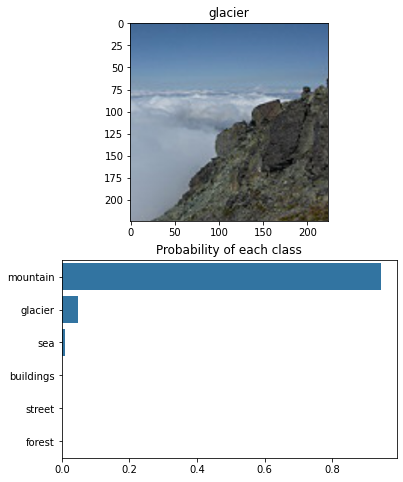

The image was classified incorrectly.


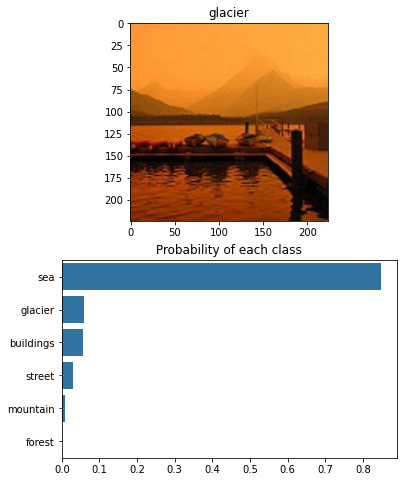

The image was classified incorrectly.


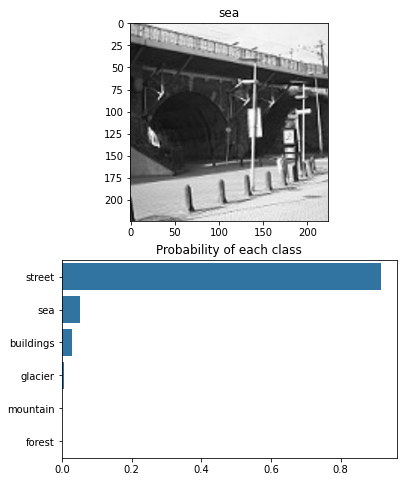

The image was classified incorrectly.


In [32]:
# Get the misclassfied data
with torch.no_grad():
  model.eval()
  classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
  images, labels = dataiter.next()
  images, labels = images.to(device), labels.to(device)
  outputs = model(images)
  outputs = outputs.cpu()
  print("Plotting misclassified data:")
  # Iterate through each image in the batch
  for i in range(len(labels)):
    outputs = model(images)
    outputs = outputs.cpu()
    output = (torch.exp(outputs[i]))
    prob, idx = torch.topk(output,6)
    # If the prediction does not match the label, plot the image and its prediction
    if labels[i] != idx[0]:
      plt.figure(figsize=(6,8))
      ax = plt.subplot(2,1,1)
      images = images.cpu()
      imshow(torchvision.utils.make_grid(images[i]), ax, title=classes[labels[i]])
      images = images.to(device)
      plt.subplot(2,1,2)
      topsix= [classes[i] for i in idx]
      sns.barplot(x=prob, y=topsix,color=sns.color_palette()[0])
      plt.title("Probability of each class")
      plt.show() 
      print("The image was classified incorrectly.")
  

# Saving and Loading Models

In [0]:
# Save the model's parameters to the directory
# If saving resnet, change model.classifier to model.fc
checkpoint_path = '/content/gdrive/My Drive/EE499/Project/Models/res501.pth'
checkpoint = {'architecture': model.name,
             'classifier': model.classifier,
              'optimizer': model.optimizer,
             'state_dict': model.state_dict()}
torch.save(checkpoint, checkpoint_path)

In [0]:
# Load the model
def load_checkpoint(path):
    
    # Load the saved file
    checkpoint = torch.load(path)
    
    # Download pretrained model
    if checkpoint['architecture'] == 'vgg19':
      model = models.vgg19(pretrained=True)
    elif checkpoint['architecture'] == 'vgg16':
      model = models.vgg16(pretrained=True)
    elif checkpoint['architecture'] == 'resnet50':
      model = models.resnet50(pretrained=True)
    elif checkpoint['architecture'] == 'squeezenet':
      model = models.squeezenet1_1(pretrained=True)
    else:
      print("The model {} picked is not from our selection.".format(checkpoint['architecture']))
      return None
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
       param.requires_grad = False
    
    # Load stuff from checkpoint
    if checkpoint['architecture'] == 'resnet50':
      model.fc  = checkpoint['classifier']
    else:
      model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    model.optimizer = checkpoint['optimizer']
    model.name = checkpoint['architecture']
    device = torch.device("cuda:0")
    model.to(device)
    return model

In [0]:
# Load the model
checkpoint_pat = '/content/gdrive/My Drive/EE499/Project/Models/resnet50.pth'
model = load_checkpoint(checkpoint_path)

# Ensemble Method

In [51]:
# Load the model
checkpoint_path_1 = '/content/gdrive/My Drive/EE499/Project/Models/vgg19_LeakyRelu_1e-1.pth'
checkpoint_path_2 = '/content/gdrive/My Drive/EE499/Project/Models/squeeze.pth'
checkpoint_path_3 = '/content/gdrive/My Drive/EE499/Project/Models/resnet50_nonaugmented_LASTLAYER.pth'
checkpoint_path_4 = '/content/gdrive/My Drive/EE499/Project/Models/VGG16_nobn_nonaugmented_LASTLAYER.pth'
model_1 = load_checkpoint(checkpoint_path_1)
model_2 = load_checkpoint(checkpoint_path_2)
model_3 = load_checkpoint(checkpoint_path_3)
model_4 = load_checkpoint(checkpoint_path_4)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
# Getting the models in a list
models = [model_1,model_2,model_3,model_4]

In [0]:
# Function to get the probabilities of all models
def model_prob(models,loader):
  probs = []
  labels = []
  for model in models:
    x, y = get_predictions(model,loader)[1:3]
    probs.append(y)
    labels = x
  return labels, probs

In [0]:
# Getting probability from the valid_loader 
labels, probs = model_prob(models,valid_loader)

In [0]:
# Function to get the optimal weights
def searchWeights(probs,labels):
  # num is a list that contains the percentages wanted
  num = np.arange(0,1.1,0.1)
  # Initialize
  best_score = 0
  count = 0
  # For each percentage calculate all possible weights
  for n in num:
    # Percentage is given to a list
    l= [n]
    # Distribute the rest of the weights
    per = (1-l[0])/(len(probs)-1)
    for i in range(len(probs)-1):
      l.append(per)
    # Convert to array for the roll function (rotate)
    l = np.array(l)
    # new tensor is made for the probabilities
    probs_new = torch.zeros([len(probs[0]),6])
    # rotate the weights for all possibilities
    for rotate in range(len(probs)):
      weights = np.roll(l,rotate)
      weights = torch.tensor(weights)
      # Add the probability of each model times its weight
      for i in range(len(probs)):
        probs_new += weights[i]*probs[i]
      # Get the predictions
      pred_labels = torch.argmax(probs_new,1)
      # Get the score
      score = accuracy_score(labels,pred_labels)
      # If the score is higher than the best score, report the weights
      if score > best_score:
        count+=1
        best_score = score
        best_weights = weights
  print("Number of times the score has been exceeded:",count)
  return best_score*100, best_weights
score, weights = searchWeights(probs,labels)

In [0]:
print("The accuracy of the validation set is: {:.2f}%".format(score))

In [0]:
labels, probs = model_prob(models,test_loader)

In [0]:
# Averages the predictions of the models, depending on the weights
# Weights are by default evenly distributed
def ensemble(probs,labels, weights = np.ones(len(probs))/len(probs)):
  new_probs = torch.zeros([len(probs[0]),6])
  for i in range(len(probs)):
    new_probs += weights[i]*probs[i]
  pred_labels = torch.argmax(new_probs,1)
  print("The accuracy of the ensemble is: {:.2f}%".format(100*accuracy_score(labels,pred_labels)))
  return pred_labels, 100*accuracy_score(labels,pred_labels)

In [0]:
preds, score = ensemble(probs,labels,weights)

The accuracy of the ensemble is: 93.98%


In [0]:
weights

tensor([0.2333, 0.3000, 0.2333, 0.2333], dtype=torch.float64)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


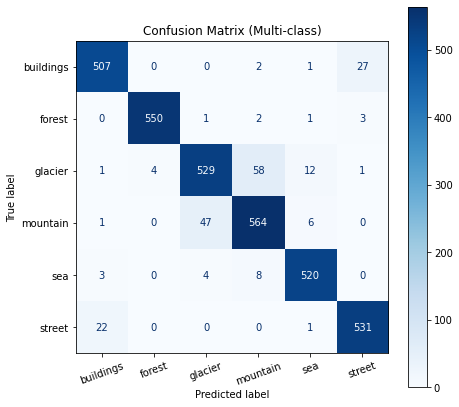

The test accuracy of the ensemble model is: 93.98%


AttributeError: ignored

In [0]:
plot_confusion_matrix(labels,preds,classes)
print("The test accuracy of the ensemble model is: {:.2f}%".format(score))

# References

[1] Dataloader: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb

[2] Early stoppping: https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb

[3] Confusion matrix: https://github.com/bentrevett/pytorch-image-classification/blob/master/4%20-%20VGG.ipynb

[4] General: https://github.com/chauhan-nitin/Udacity-ImageClassifier/blob/master/Image%20Classifier%20Project.ipynb

# Notable Mentions
We have tried using the non augmented train loader to obtain the loss and accuracy when training with augmented data. But the training time has more than quadrupled due to the training set being huge. This method turned out to be infeasible.




In [0]:
# Using non augmented train loader to obtain the training loss and accuracy

# #save = '/content/gdrive/My Drive/EE499/Project/vgg19_ver0.1-transfer.pt'
# save = '/Data/VGG19_ver0.3-transfer.pt'
# checkpoint_path = '/content/gdrive/My Drive/EE499/Project/vgg19-transfer.pth'

# def train(model,
#           criterion,
#           optimizer,
#           train_loader,
#           valid_loader,
#           train_nonaug_loader,
#           save_file,
#           early_stop_epochs=8,
#           epochs = 100):
  
#   start_training_time = time.time()
#   start = time.time()
#   history = []
#   epochs_no_improve = 0
#   valid_loss_min = np.Inf

#   valid_max_acc = 0
#   print("The training process has started. \n")
#   for e in range(epochs):
#       running_loss = 0
#       model.train() 
#       total_train = 0
#       correct_train = 0
#       steps = 0
      
#       for ii, (inputs, labels) in tqdm(enumerate(train_loader),total=len(train_loader),desc='Epoch progress'):
#           steps += 1
          
#           inputs, labels = inputs.to(device), labels.to(device)
          
#           optimizer.zero_grad()
          
#           # Forward and backward passes
#           outputs = model.forward(inputs)
#           loss = criterion(outputs, labels)
#           loss.backward()
#           optimizer.step()
          
#           running_loss += loss.item()
          
#           # _, predicted = torch.max(outputs,1)
#           # total_train += labels.nelement()
#           # correct_train += predicted.eq(labels).sum().item()
#           # train_acc = correct_train/total_train
#       model.eval()

#       with torch.no_grad():
#           valid_loss, valid_acc = validation(model, valid_loader, criterion)
#           train_loss, train_acc = validation(model, train_nonaug_loader, criterion)

#       print("Epoch: {}/{} | ".format(e+1, epochs),
#             "Training Loss: {:.4f} | ".format(train_loss/len(train_loader)),
#             "Training Accuracy: {:.2f}% |".format(100*train_acc/len(train_loader)),
#             "Validation Loss: {:.4f} | ".format(valid_loss/len(valid_loader)),
#             "Validation Accuracy: {:.2f}% |".format(100*valid_acc/len(valid_loader)),
#             "Time elapsed: {:.2f} seconds".format((time.time()-start)))
#       start = time.time()
#       history.append([train_loss/len(train_loader),100*train_acc/len(train_loader),valid_loss/len(valid_loader),100*valid_acc/len(valid_loader)])
#       if valid_loss/len(valid_loader) < valid_loss_min:
#         torch.save(model.state_dict(), save_file)
#         epochs_no_improve = 0
#         valid_loss_min = valid_loss/len(valid_loader)
#         valid_best_acc = 100*valid_acc/len(valid_loader)
#         best_epoch = e+1
#       else:
#         epochs_no_improve += 1
#         if epochs_no_improve >= early_stop_epochs:
#           print("Early Stopping...Total epochs: {}. Best epoch: {} with loss: {:4f} and accuracy: {:.2f}".format(e+1,best_epoch,valid_loss_min,valid_best_acc))
#           model.load_state_dict(torch.load(save_file))
#           model.optimizer = optimizer
#           history = pd.DataFrame(
#                     history,
#                     columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
#           return model, history


#       model.train()
#   end_training_time = time.time()
#   model.load_state_dict(torch.load(save_file))
#   model.optimizer = optimizer
#   history = pd.DataFrame(
#     history,
#     columns=['train_loss','train_acc', 'valid_loss', 'valid_acc'])
#   print('\nTraining of the model was completed in {:.2f} minutes.'.format((end_training_time-start_training_time)/60))
#   return model, history

In [0]:
# New code of ensemble takes any number of models
# def ensemble(model_1, model_2, loader, weights = [0.5, 0.5]):

#     model_1.eval()
#     model_2.eval()

#     imagesl = []
#     labelsl = []
#     probs1 = []
#     probs2 = []
#     probs = []

#     with torch.no_grad():

#         for (images, labels) in loader:
#             # Loading the images to CUDA
#             images = images.to(device)
#             # Getting the logarithmic probabilites to each model
#             y_pred1 = model_1(images)
#             y_pred2 = model_2(images)
#             # Getting the probablities to each model
#             y_prob1 = torch.exp(y_pred1)
#             y_prob2 = torch.exp(y_pred2)
#             # Getting the final probability by weight
#             y_prob = weights[0]*y_pred1 + weights[1]*y_pred2

#             # Append data to their respective lists
#             labelsl.append(labels.cpu())
#             probs1.append(y_prob1.cpu())
#             probs2.append(y_prob2.cpu())
#             probs.append(y_prob.cpu())
#     # Convert to tensors
#     labels = torch.cat(labelsl, dim = 0)
#     probs = torch.cat(probs, dim = 0)
#     probs1 = torch.cat(probs1, dim = 0)
#     probs2 = torch.cat(probs2, dim = 0)
#     # Get predictions
#     pred1 = torch.argmax(probs1, 1)
#     pred2 = torch.argmax(probs2, 1)
#     pred_labels = torch.argmax(probs, 1)
#     # Get accuracies
#     acc1 = accuracy_score(labels,pred1)
#     acc2 = accuracy_score(labels,pred2)
#     acc_ensemble = accuracy_score(labels,pred_labels)
#     # Empty VRAM
#     torch.cuda.empty_cache()
#     print("The accuracy of the first model is : {:.2f}%\nThe accuracy of the second model is: {:.2f}%\nThe accuracy of the ensemble model is: {:.2f}%".format(acc1*100,acc2*100,acc_ensemble*100))
#     return  labels, probs, pred_labels